## EE 502 P: Analytical Methods for Electrical Engineering
    
# Homework 9: ML
## Due 4 December, 2019 at 6:00 PM
### <span style="color: red">YOUR NAME HERE</span>

Copyright &copy; 2019, University of Washington

<hr>

**Instructions**: Use this notebook as a template. Answer all questions using well formatted Markdown with embedded LaTeX equations, executable Jupyter cells, or both. Submit your homework solutions as an `.ipynb` file via Canvas.

<span style="background: yellow; padding: 6px; border: 1pt solid black">
Although you may discuss the homework with others, you must turn in your own, original work.
</span>

**Things to remember:**
- Use complete sentences. Equations should appear in text as grammatical elements.
- Comment your code.
- Label your axes. Title your plots. Use legends where appropriate. 
- Before submitting a notebook, choose Kernel -> Restart and Run All to make sure your notebook runs when the cells are evaluated in order. 

Note : Late homework will be accepted up to one week after the due date and will be worth 50% of its full credit score. 

### 0. Warmup (Do not turn in)

- Make sure you get download, read, and run the notebooks for lecture 9. Work through the notebook cell by cell and see what happens when you change the expressions, and make up some of your own.
- Most of the lecture notes come from two sources. The first is the following book:
    > Goodfellow, [Deep Learning](http://www.deeplearningbook.org/). 

  and the other is the pytorch web page. In particular, the [tutorial page](https://pytorch.org/tutorials/) is great. 
 



In [10]:
import math
import numpy as np
import sympy as sm
sm.init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
import random
#import torch
#import torch.nn as nn
#import torch.nn.functional as F

%matplotlib inline

### 1. XNOR 

Recall the two layer network with two inputs and two hidden nodes corresponds to the equations below, where $g$ is the Rectified Linear Unit function. **By hand, find weights and biases so that this network computes the XNOR function** (instead of XOR as shown in class. 

$$
\begin{pmatrix} x_3 \\ x_4 \end{pmatrix} = 
g \left ( 
    \begin{pmatrix}
      w_{13} & w_{23} \\
      w_{14} & w_{24}
    \end{pmatrix}
      \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} 
    + \begin{pmatrix}b_3 \\ b_4\end{pmatrix} 
\right )
$$

and

$$
x_5 = 
g \left ( 
      \begin{pmatrix} w_{35} & w_{45} \end{pmatrix}
      \begin{pmatrix} x_3 \\ x_4 \end{pmatrix} 
    + b_5 
\right )
$$

with 

$y = x_5$ being the output.

***
1)


**We need to determine the parameters**:
$$\theta = (W, w^T, b, c).$$
See script below for one possible method.

---
Once we have the parameters,the computations follow.

On the input $(0 \; 0)^T$ the first layer of the network computes

$$
\begin{pmatrix} x_3 \\ x_4 \end{pmatrix} = 
g 
\left ( 
W
\begin{pmatrix} 0 \\ 0 \end{pmatrix} 
    + c
\right ) = g \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
         = \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
$$

and the second layer computes 

$$
x_5 = 
g \left ( 
      w^T
      \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
    + b_5
\right ) = g(\cdot) = 1 .
$$



---

On the input $(0 \; 1)^T$ the first layer of the network computes

$$
\begin{pmatrix} x_3 \\ x_4 \end{pmatrix} = 
g 
\left ( 
W
\begin{pmatrix} 0 \\ 1 \end{pmatrix} 
    + c
\right ) = g \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
         = \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
$$

and the second layer computes 

$$
x_5 = 
g \left ( 
      w^T
      \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
    + b_5
\right ) = g(\cdot) = 0.
$$


---

On the input $(1 \; 0)^T$ the first layer of the network computes

$$
\begin{pmatrix} x_3 \\ x_4 \end{pmatrix} = 
g 
\left ( 
W
\begin{pmatrix} 1 \\ 0 \end{pmatrix} 
    + c
\right ) = g \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
         = \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
$$

and the second layer computes 

$$
x_5 = 
g \left ( 
      w^T
      \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
    + b_5
\right ) = g(\cdot) = 0.
$$


---

On the input $(1 \; 1)^T$ the first layer of the network computes

$$
\begin{pmatrix} x_3 \\ x_4 \end{pmatrix} = 
g 
\left ( 
W
\begin{pmatrix} 1 \\ 1 \end{pmatrix} 
    + c
\right ) = g \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
         = \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
$$

and the second layer computes 

$$
x_5 = 
g \left ( 
      w^T
      \begin{pmatrix} \cdot \\ \cdot \end{pmatrix} 
    + b
\right ) = g(\cdot) = 1 .
$$


In [43]:
# Change All these PARAMETER values
# Hint: Possible values you should consider are combinations of -2, -1, 0, 1, 2

W = None
c = None
b = None
in1 = np.array([[0],[0]]) # 2x1 vector
in2 = np.array([[0],[1]])
in3 = np.array([[1],[0]])
in4 = np.array([[1],[1]])

while(1):
    w13,w23,w14,w24 = random.randint(-2,3),\
                        random.randint(-2,3),\
                        random.randint(-2,3),\
                        random.randint(-2,3)
    W = np.array([[w13,w23],
                  [w14,w24]])
    
    c = np.array([
        [random.randint(-2,3)],   # b3
        [random.randint(-2,3)]    # b4
    ])
    
    # b5 bias value, # Change this
    b = random.randint(-2,3)
    
    # 2nd layer weight vector: [w35, w45] # Change these
    w = np.array([[random.randint(-2,3)],[random.randint(-2,3)]])
    
    def g(x):
        '''A simple ReLU function'''
        return np.maximum(np.zeros_like(x), x) # np.maximum takes the elementwise maximum

    def f(ins):
        '''A simple neural network computation like in class'''
        return g(w.transpose() @ g(W @ ins + c) + b)

    # Truth table output
    output = f(in1).tolist()[0]+\
                f(in2).tolist()[0]+\
                f(in3).tolist()[0]+\
                f(in4).tolist()[0] 
    outputNP = np.array(output)
    while (np.max(outputNP)>1):
        outputNP = outputNP - 1
    if output == [1,0,0,1]:
        print('FOUND')
        print(W)
        print(c)
        print(b)
        break

FOUND
[1, 0, 0, 1]
[[ 2  2]
 [-1 -1]]
[[-2]
 [ 3]]
-2


In [44]:
# Use W,c,b found in while and compute network function
def f(ins,W,c,b):
    '''Computes Neural network with given W,c,b'''
    return g(w.transpose() @ g(W @ ins + c) + b)

f(in1,W,c,b),f(in2,W,c,b),f(in3,W,c,b),f(in4,W,c,b)

(array([[1]]), array([[0]]), array([[0]]), array([[1]]))

## Some Resources:

- https://playground.tensorflow.org/#activation=relu&regularization=L2&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2,1&seed=0.00814&showTestData=false&discretize=false&percTrainData=90&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false


- https://medium.com/@lucaspereira0612/solving-xor-with-a-single-perceptron-34539f395182

**Math Resources:**

- The Matrix Calculus You Need For Deep Learning: https://explained.ai/matrix-calculus/


- Practical Guide to Matrix Calculus for Deep Learning: https://pdfs.semanticscholar.org/d5cd/a24863b9b6021191c164bde0a197b74115c1.pdf


- Mathematics for Machine Learning (paper): https://gwthomas.github.io/docs/math4ml.pdf


- Mathematics for Machine Learning (book): https://mml-book.github.io/book/mml-book.pdf


**Using the Sigmoid Fuction Instead:**
- http://neuralnetworksanddeeplearning.com/chap1.html


- https://www.coursera.org/lecture/machine-learning/examples-and-intuitions-ii-solUx


- https://chih-ling-hsu.github.io/2017/08/30/NN-XOR


- http://holehouse.org/mlclass/08_Neural_Networks_Representation.html

### 2. PyTorch

**Modify the PyTorch example below so that it learns to classify inputs with a 3x3 checkerboard** instead of the 2x2 checkerboard shown in class. Answer the following questions

a) What is the effect of changing the learning rate to 0.01?

b) What is the effect of changing the learning rate to 0.001?

c) What is the effect of using only 2 nodes in the hidden layer? 

d) What is the effect of using 2000 nodes in the hidden layer? 

Note that if this code does not work on your laptop, you probably need to install PyTorch. Alternatively, you could use Google CoLab.

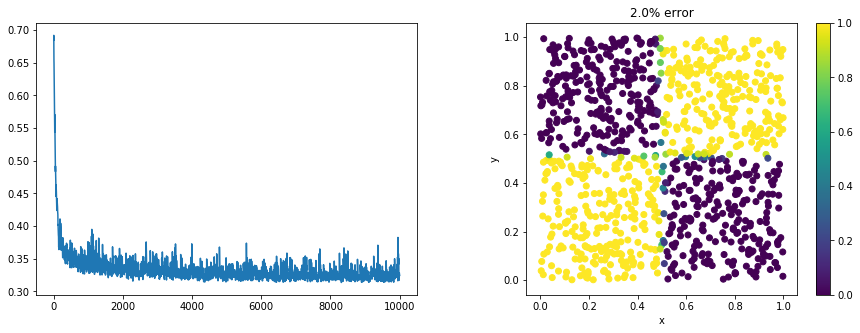

In [27]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

# First, we define a class that returns a neural network with
# two fully connected layers
class ModelTwo(nn.Module): # number of Hidden layers
    def __init__(self,size):
        super(ModelTwo, self).__init__()
        self.fc1 = nn.Linear(2,size)
        self.fc2 = nn.Linear(size,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        # Turns each output into a probability
        # distribution over {0,1}. In this case 
        # it returns (e^x1 e^x2) / ( e^x1 + e^x2 ).
        x = F.softmax(self.fc2(x),dim=1) 
        return x
    
class ModelThree(nn.Module): # number of Hidden layers
    def __init__(self,size):
        super(ModelTwo, self).__init__()
        self.fc1 = nn.Linear(3,size)
        self.fc2 = nn.Linear(size,3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        # Turns each output into a probability
        # distribution over {0,1}. In this case 
        # it returns (e^x1 e^x2) / ( e^x1 + e^x2 ).
        x = F.softmax(self.fc2(x),dim=1)  
        return x
    
def make_data_OLD(n):
    x = torch.rand(n,2)
    y = torch.tensor([
        (q[0]<0.5 and q[1]<0.5) or # Change the conditional
        (q[0]>0.5 and q[1]>0.5)
        for q in x
    ],dtype=torch.long)     
    return x,y

def make_data(n):
    x = torch.rand(n,2)
    y = torch.tensor([
        (q[0]>2/3 and q[1]<1/3) or
        (q[0]>2/3 and q[1]>2/3) or
        ((q[0]>1/3 and q[0]<2/3) and (q[1]>1/3 and q[1]<2/3) or
        (q[0]<1/3 and q[1]<1/3) or
        (q[0]<1/3 and q[1]>2/3)
        for q in x
    ],dtype=torch.long)     
    return x,y

def show_predictions(model, ax):
    x,y = make_data(1000)
    yhat = model(x)
    prediction = torch.argmax(yhat,dim=1) 
    err = 100 * torch.sum(torch.abs(y - prediction)) / 1000
    p = ax.scatter(x[:,0], x[:,1], c=yhat[:,1].detach(), vmin=0, vmax=1)
    ax.set_aspect(1)  
    ax.set_title("%0.1f%% error" % err)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(p)    

model = ModelTwo(2000) # 100 neurons in the hidden layer helps assure that some reachable
                      # local minima computes the right function. In the trained model,
                      # some neurons may not do anything useful. 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # LEARNING RATE

data = []

fig,ax=plt.subplots(1,2,figsize=(15,5))

for _ in range(1000):
    x,y = make_data(100) 
    for _ in range(10): # Might have to change this for accuracy!
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat,y)
        data.append(loss)
        loss.backward() 
        optimizer.step()

ax[0].plot(data)
show_predictions(model, ax[1])    

***
2.a)



***
2.b)



***
2.c)



***
2.d)



### Some Resources:

#### Start here for installations:
- https://deeplizard.com/learn/video/UWlFM0R_x6I

#### Then move to:
- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html


- https://pytorch.org/tutorials/beginner/ptcheat.html


- http://colah.github.io/posts/2014-07-Conv-Nets-Modular/


- http://colah.github.io/posts/2014-07-Understanding-Convolutions/

#### Other:
- https://deeplizard.com/learn/video/gZmobeGL0Yg


- Bias-Variance and Error Analysis: http://cs229.stanford.edu/section/error-analysis.pdf

### 3 Literature

Read the following three articles and then answer the questions below. Note that if you are not at UW you may need to use the [library proxy system](https://www.lib.washington.edu/help/connect) to get access to these papers.

- [Deep Learning](https://www-nature-com.offcampus.lib.washington.edu/articles/nature14539)
- [How To Deal With Machine Learning Papers](https://blogs.sciencemag.org/pipeline/archives/2019/11/20/how-to-deal-with-machine-learning-papers)

Answer

- a) Why are local minima not a problem in large neural networks?
- b) Why might scientists be skeptical of the use neural networks to understand scientific data?
- c) Computational neural networks were not considered practical in the 1990s. What changed?
- d) What safety and security issues are unique to the use of neural networks for engineering purposes?
- e) What are three applications of machine learning you had not heard of that sound interesting to you?
- f) What are the limitations of deep learning?

***
3.a)

Why are local minima not a problem in large neural networks?

438 and 439 from Deep Learning

***
3.b)

Why might scientists be skeptical of the use neural networks to understand scientific data?



***
3.c)

Computational neural networks were not considered practical in the 1990s. What changed?



***
3.d)

What safety and security issues are unique to the use of neural networks for engineering purposes?



***
3.e)

What are three applications of machine learning you had not heard of that sound interesting to you?



***
3.f)

What are the limitations of deep learning?



### Some Resources:

- A Few Useful Things to Know About Machine Learning: https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf


- CS229 Lecture Notes- Deep Learning: http://cs229.stanford.edu/notes/cs229-notes-deep_learning.pdf


- Convolutional Neural Networks for Visual Recognition Course: http://cs231n.github.io/